# ASTR302 Lab 4: Removing Instrumental Signatures and Making a Final CCD Image

In this Lab you will how to remove the basic instrumental signatures in a CCD image.

## Removing the Bias

The nature of counting statistics and many other sources of noise, namely that they are symmetric and Gaussian distributed, hits a wall when confronted with the positive definite quality of signal detection. To maintain the statistically nice properties of Gaussian noise, we (more accurately whomever constructed the CCD camera you are using) typically move the average value of a pixel away from 0, even when the camera shutter is left closed and the exposure time is equal to 0 seconds. The numerical fact then that a signal of 0 is equal to some positive non-zero value is referred to as a bias or sometimes as a 'fat zero'.

This is a purely fictional added value devised by the read out electronics. There are less standard ways of actually generating charge in the pixels by briefly flashing them with light. This is typically called a pre-flash and is generally done for other reasons that we will discuss elsewhere. 

Because the bias is added in the read-out electronics, we can also just have the CCD do additional reads even once all of the pixels in the register are read out. This will add apparent extra pixels to the final image that you have, although these extra pixels do not correspond to real pixels on the detector. These will have only the bias in them, independent of whether the exposure time was not zero and the shutter was open or closed. When we do this for each row, we create a vertical band of bias columns (could also be a set of rows) that is called the overscan region. We will use this region to measure the bias level that we will then subtract from the image.


Before we start, lets import the packages you will be needing for this Lab and take a look at an image. We use the fits image format. You can learn about the fits utilities in astropy at https://docs.astropy.org/en/stable/io/fits/index.html

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

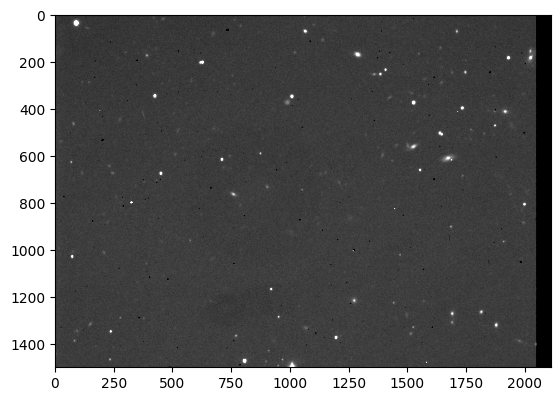

In [32]:
# define the image, open, and read the header information
filename = 'imacs_image1.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

# plot the image, with minimum and maximum levels set by hand
ax = plt.subplot()
ax.imshow(image,cmap='gray',vmin=1100,vmax=1480)

Here is an image of the sky. You can see point sources, which are most likely stars, and resolved objects, which are most likely galaxies. You can also see the dark band on the right hand side - this is the overscan region. The bias is added throughout the image, and yet the overscan region is darker than the rest of the image. <div class="alert alert-info">Why is this so? </div>

<div class="alert alert-block alert-success">
Answer: The overscan region appears darker than the rest of the image when a bias is applied because the overscan area is not exposed to light(in this case the sky), meaning it only captures electronic noise(bias) from the sensor, while the rest of the image contains both the bias and the actual light signal from the scene being captured. 
</div>

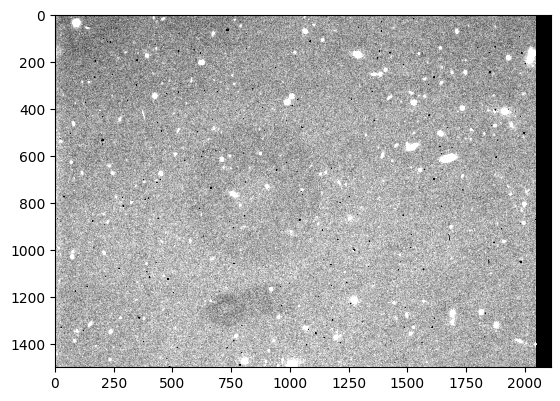

In [33]:
# define the image, open, and read the header information
filename = 'imacs_image1.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

# plot the image, with minimum and maximum levels set by hand
ax = plt.subplot()
ax.imshow(image,cmap='gray',vmin=1150,vmax=1210)

It is always good practice to take a close look at your data to find flaws and limitations. Lets take a look at the same image above, but this time scale the image so that we only display pixel values between 1150 and 1210. <div class="alert alert-info">Describe what you see now?</div>

<div class="alert alert-block alert-success">
Answer: After changing the displayed pixel values, the picture outside of the overscan is much brighter with a lot more noise. You can also see spots along the picture where you can see points or even a circle that is darker than the rest of the image where you can tell that something interfered with the telescope such as dust or something else. In general the picture shows a lot more bright spots that might be stars. Displaying only the pixel values between 1150 and 1210 is essentially enhancing the contrast to a narrow range of intensity values. This brings out subtle variations in brightness that were not previously visible. This is shown in this image as you can see more bright spots which are stars in the sky than before when the picture was darker.
</div>

Now, lets work on subtracting the bias level. We will determine the bias level using the overscan region and then trim the image so that it no longer has the overscan region (we don't need it anymore once we've measured and subtracted off the bias level). 

First, we need to determine the region of the image that the overscan region occupies. Lets do that by taking cuts across and image.

Text(0.5, 0, 'Column')

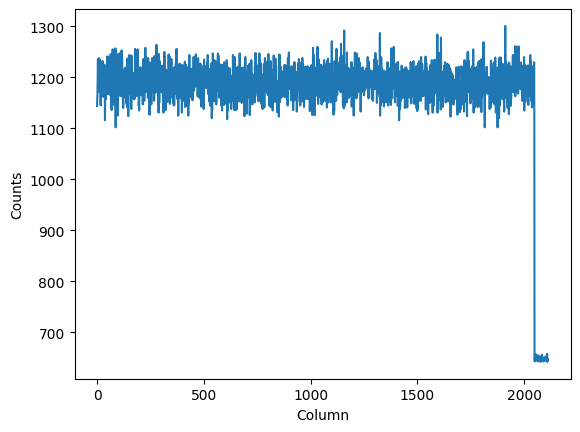

In [34]:
# lets plot a cut at row 820 (row was arbitrarily chosen)
ax = plt.subplot()
ax.plot(image[820,:])
ax.set_ylabel('Counts')
ax.set_xlabel('Column')

(2050.0, 2100.0)

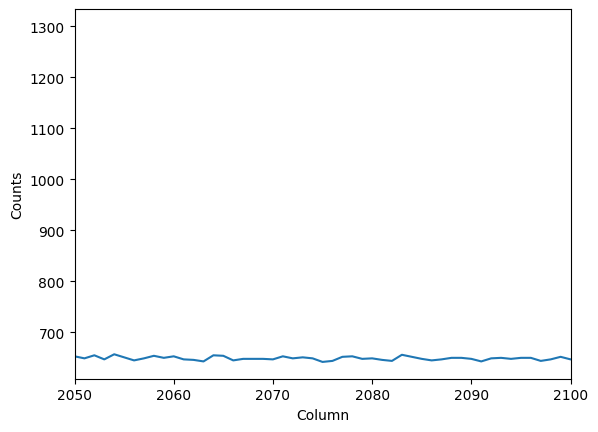

In [35]:
# lets plot a cut at row 820 (row was arbitrarily chosen)
ax = plt.subplot()
ax.plot(image[820,:])
ax.set_ylabel('Counts')
ax.set_xlabel('Column')
plt.xlim(2050, 2100)

<div class="alert alert-info">What pixels define the overscan region? You can zoom in the plot if you need to get a better idea. </div>

<div class="alert alert-block alert-success">
Answer:the pixels that define the overscan region would be columns 2000+ and counts around 650
</div>

Now lets plot the overscan region in the vertical direction to see if we can model it as a constant value or if it drifts as a function of the row number. Plot the average across the overscan region as a function of the row. Stay away from the edge near the live area of the CCD when calculating the averages just to be safe.


1500 2112


Text(0.5, 0, 'Row')

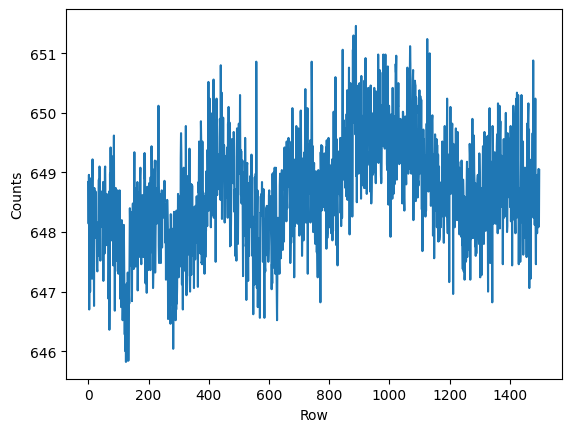

In [36]:
# plot of the overscan region...
# Hint: it turns out the first row has junk in it (the edges of images are often problematic)
# so, ignore the first row (which in the image is actually the top row)

# get size of image
h, w = image.shape
print(h,w)
#initialize overscan array
overscan = []

# calculate mean overscan values
for i in range(1,h):
    overscan = np.append(overscan,image[i, w-50:w].mean())

ax = plt.subplot()
ax.plot(overscan)

ax.set_ylabel('Counts')
ax.set_xlabel('Row')

You should see that there is systematic structure in the bias (it isn't just random noise). Most often people fit a polynomial to this structure and then subtract that model off the data. Here we will keep it simple and just ask you to subtract the mean value. Go ahead code that in and also trim the image to not have the overscan region or that pesky first row. 

By the way, you should also do the exact same thing to all of the images you have because they all have bias in them and the same overscan geometry.

Mean bias value: 648.675610406938


Text(0.5, 1.0, 'Bias Image3')

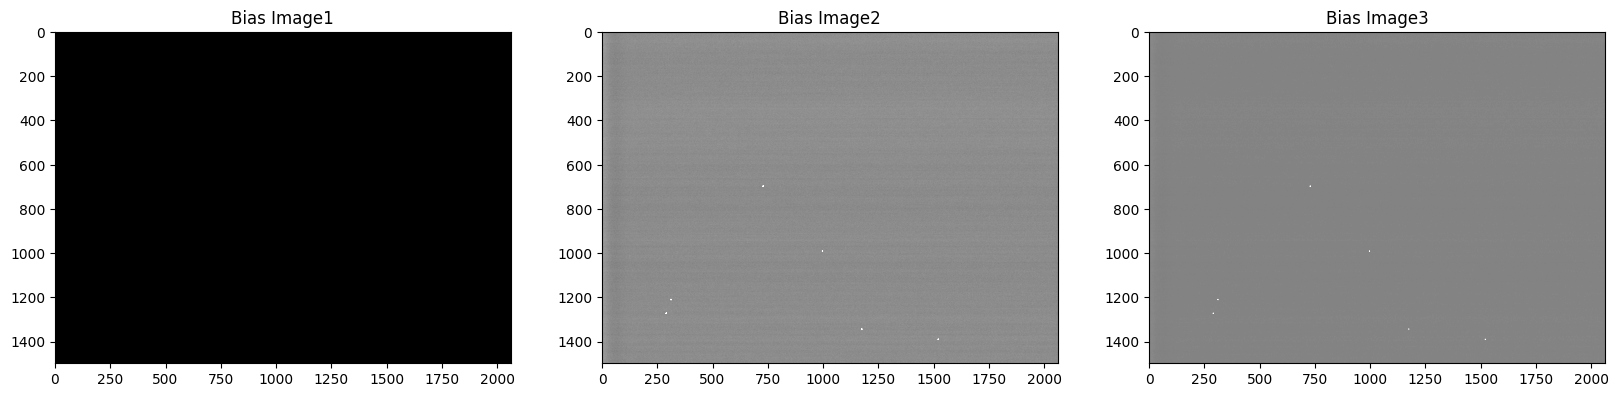

In [45]:
# lets load in the other images
filename = 'imacs_bias2.fits'
hdu = fits.open(filename)[0]
bias_image = hdu.data
bias_hdr = hdu.header

filename = 'superflat1.fits'
hdu = fits.open(filename)[0]
flat_image = hdu.data
flat_hdr = hdu.header

# mean overscan value
bias = overscan.mean()
print("Mean bias value:", bias)

#subtract bias and trim image for all images
def subtract_bias_and_trim(image, bias, trim_overscan=True):
    h, w = image.shape
    if trim_overscan:
        # Trim the overscan region (last 50 columns) and subtract bias
        return image[1:, :-50] - bias
    else:
        # Do not trim the overscan region, just subtract bias
        return image[1:, :] - bias

bias_image_trimmed = subtract_bias_and_trim(bias_image, bias, trim_overscan=True)
flat_image_trimmed = subtract_bias_and_trim(flat_image, bias, trim_overscan=True)


# plot the image, with minimum and maximum levels set by hand
fig, axs = plt.subplots(1, 3,figsize=(20,8))

ax1 = plt.subplot(131)
ax1.imshow(bias_image_trimmed, cmap='gray', vmin= 0, vmax= 0)
ax1.set_title('Bias Image1')

ax2 = plt.subplot(132)
ax2.imshow(bias_image_trimmed, cmap='gray', vmin= -50, vmax= 50)
ax2.set_title('Bias Image2')

ax3 = plt.subplot(133)
ax3.imshow(bias_image_trimmed, cmap='gray', vmin= -150, vmax= 150)
ax3.set_title('Bias Image3')

Take a look at all three images above. Did the trimming work like you expected? The object frame clearly still has residual structure that you can also see in the middle image, which is the superflat. We'll get to flat fielding next. Before moving on, lets take a look at the bias frame (the third one). There is clearly some structure left (partly because we didn't fit the vertical structure and just subtracted a mean value). We could go back and refit, or we could subtract this 2-d frame from the data and flat field frames. For now we're going to ignore this, but you should always be cognizant of remaining structure in your bias frames and subtract it if necessary (make sure that the structure is greater in value than the noise because any subtraction process is going to introduce the noise into your image). 

## Flatfielding

Flatfielding is the process by which you remove sensitivity variations across the detection. The basic principle is that if take an image of something that is uniform across the field of view, then any variations you see in that image are due to sensitivity variations in the detector. If you then divide your object frames by the image of the uniform source you will be 'dividing out' the sensitivity variations. 

What I am providing (the superflat) is one way to obtain such an image. Typically you take exposures of the inside of the dome (way out of focus) or a flat field screen mounted on the inside of the dome to mimic a uniform field. I didn't have such an exposure for this data so I did something that is also commonly done. I took the median of many exposures of the sky, hoping that the real objects (stars, galaxies) don't land on top of each other often and that the median just gives me an image of the smooth background sky (which is assumed to be uniform, but really isn't). Because I didn't have that many such frames with which to take the median, it didn't work perfectly (you can still see some residual images of bright stars). Nevertheless, we're going to go ahead and divide it out. 

First, before dividing it into the data, we will normalize the superflat (set it to have mean = 1) so that when we divide it into other frames we do not change their mean counts. Lets do all of that and take a look at the result.

Mean bias value: 648.675610406938


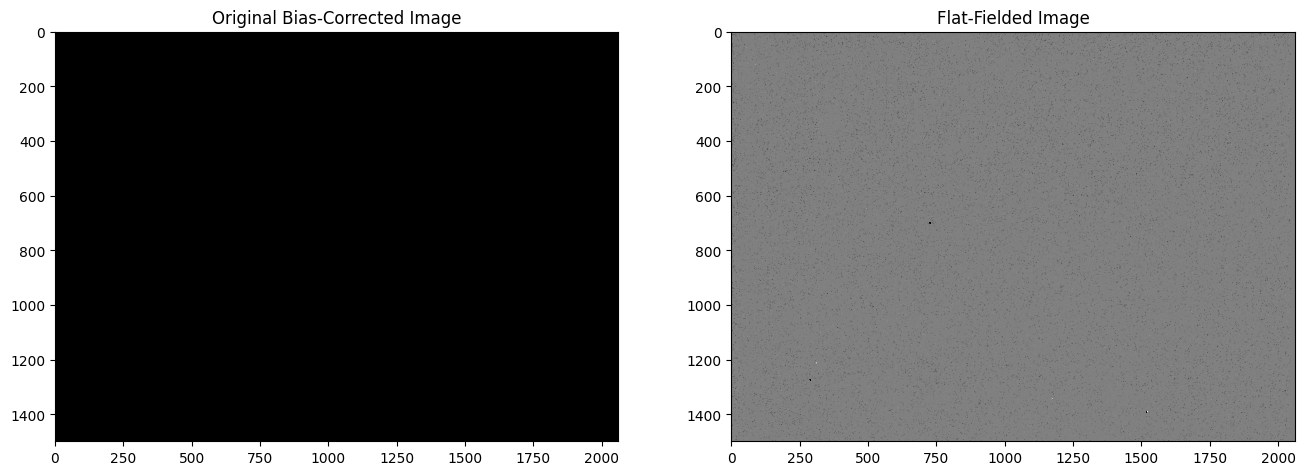

In [47]:
# mean overscan value
bias = overscan.mean()
print("Mean bias value:", bias)

# Normalize the superflat image so that its mean value is 1
def normalize_image(image):
    return image - np.mean(image)

# Normalize the flat image
#normalized_superflat = normalize_image(flat_image_trimmed)

# Divide the image by the normalized flat (superflat)
def flat_field_correction(image, superflat):
    return image / superflat

# Apply flat-field correction to the bias-corrected and trimmed image
final_image = flat_field_correction(bias_image_trimmed, normalized_superflat)

fig, axs = plt.subplots(1, 2,figsize=(16,8))

# Plot the original bias-corrected image
axs[0].imshow(bias_image_trimmed, cmap='gray', vmin= 0 , vmax= 0)
axs[0].set_title('Original Bias-Corrected Image')

# Plot the final flat-fielded image
axs[1].imshow(final_image, cmap='gray', vmin=-50, vmax=50)
axs[1].set_title('Flat-Fielded Image')

plt.show()

# write out your final reduced image (you'll need it for the next workbook
fits.writeto('save.fits', final_image, hdr, overwrite = True)

<div class="alert alert-info">How did that work? Did it improve things? <div>

Answer:

## Conclusion: 

<div class="alert alert-info"> Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L. </div>